In [1]:
import jVMC
import jax
#from jax.config import config
jax.config.update("jax_enable_x64", True)
import jax.random as jrnd
import jax.random as random

import jax.numpy as jnp
from functools import partial
import numpy as np
import jVMC.global_defs as global_defs
from tqdm import tqdm
import matplotlib.pyplot as plt
@jax.jit
def sorting_gumble(sample,logits,gumbel,states):
    indexes = jnp.argsort((-gumbel),axis=None)#.reshape(shape_gumbel)
    numSamples = sample.shape[0]
    ldim = sample.shape[1]
    L = sample.shape[2]
    #jax.debug.print("shape {x},{y},{z}",x=numSamples,y=ldim,z=L)
    indexes_states = (indexes // ldim)[:numSamples]
    sample = sample.reshape(-1,L)[indexes]
    sample = sample.reshape(ldim,numSamples,L)
    sample = jnp.swapaxes(sample,0,1)
    
    logits = logits.ravel()[indexes]
    logits = logits.reshape(ldim,numSamples).T
    
    gumbel = gumbel.ravel()[indexes]
    gumbel = gumbel.reshape(ldim,numSamples).T

    vals, treedef  = jax.tree_util.tree_flatten(states)
    vals_ordered = [v[indexes_states] for v in vals]
    states = jax.tree_util.tree_unflatten(treedef,vals_ordered)
    return sample,logits,gumbel,states

In [2]:
class MCSampler_gumbel(jVMC.sampler.MCSampler):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args, **kwargs)
        try: 
            callable(self.net.net.forward_with_state)
        except:
            try:
                callable(self.net.net.net.forward_with_state)
            except:
                raise Exception("neural network has no autoregressive stepwise sampling subroutine 'forward_with_state'")
    def setup_gumble(self):
        try:
            self.ldim = self.net.net.LocalHilDim
            self.lowNet = self.net.net
            self.psiNet = self.net

        except:
            self.lowNet = self.net.net.net
            self.psiNet = self.net.net

        self.ldim = self.lowNet.LocalHilDim
        self.Q = self.lowNet.Q
        #self.netcall = self.lowNet.apply
        self.netcall = self.net.net.apply
        
        self.L = self.sampleShape[0]
        
        self.max_particles = jnp.pad((self.ldim-1)*jnp.arange(1,self.L+1)[::-1],(0,1))[1::]
        self.must_mask = 2 * jnp.tril(jnp.ones((self.ldim,self.ldim)),k=-1)
        self.can_mask = jnp.flip(self.must_mask)
        print(self.Q)
    def _workN(self,sample,logits,gumbel,key,states,position):
        
        particles_left = self.Q - jnp.sum(sample[0]+jnp.abs(sample[0]))//2
        #new samples with (0,..,ldim-1) at position
        sample = jnp.array([sample[0].at[position].set(l) for l in jnp.arange(self.ldim)])
        #right shifted input
        inputt = jnp.array([jnp.pad(sample[0,:-1],(1,0))])
        # sampling outside psi --> need to give parameters manually
        para = self.net.parameters
        #if "net" in para:
        #    paraA = para["net"]
        #else:
        #    paraA = para
        logitnew, next_states = self.netcall(para,inputt[:,position],block_states = states, output_state=True)
    
        #jax.debug.print("pl: {x}",x=particles_left)
        must_give = jax.nn.relu(particles_left-self.max_particles[position])

        # number of particles that can be assigned
        can_give = jnp.minimum(particles_left, self.ldim-1)
        mask = (self.must_mask[must_give] + 
                    self.can_mask[can_give.astype(int)]) 
        #logit_renorm =  logitnew - mask ** jnp.inf
        #jax.debug.print("mask {x}", x=mask)
        logitnew =  jax.nn.log_softmax(logitnew - mask ** jnp.inf)
        #jax.debug.print("logits new {x}", x=logitnew)
        #jax.debug.print("logits[0] {x}", x=logits[0])
        
        logitnew = logits[0] + logitnew - mask ** jnp.inf
        #jax.debug.print("logits new {x}", x=logitnew)

        #gumbelnew = logitnew + jrnd.gumbel(key[0],shape=(self.ldim,))
        gumbelnew = logits[0] + jrnd.gumbel(key[0],shape=(ldim,))
        #jax.debug.print("gumbelnew new {x}", x=gumbelnew)

        Z = jnp.max(gumbelnew)
        gumbelnew = jnp.nan_to_num(-jnp.log(jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(gumbelnew)),copy=True,nan=-jnp.inf)
        #gumbelnew = (-jnp.log(jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(gumbelnew)))
        gumbelnew = gumbelnew- mask ** jnp.inf
        return sample, logitnew, gumbelnew, next_states
        #return sample,logits,gumbel,states
    #@jax.jit
    def scan_fn(self,carry, key):
        position = key[1]
        sample = carry[0]
        #jax.debug.print("{x}", x=sample)

        logits = carry[1]
        gumbel = carry[2]
        states = carry[3]
        keys = jrnd.split(key[0],(carry[0].shape[0],1))

        p_workN = partial(self._workN,position=position)
        sample,logits,gumbel,states = jax.vmap(p_workN)(sample,logits,gumbel,keys,states)
        #jax.debug.print("gumbelnew new {x}", x=gumbel)

        #### sorting gumble value
        return sorting_gumble(sample,logits,gumbel,states),None
        
    def gumbel(self,numSamples, tmpKey, parameters):
        shape_samples = (numSamples,self.ldim,self.L)
        shape_logits = (numSamples,self.ldim)
        shape_gumbel = (numSamples,self.ldim)
        #print(shape_samples,shape_logits)
        working_space_samples = jnp.full(shape_samples,-2,dtype=jnp.int64)
        working_space_logits = jnp.full(shape_logits,-jnp.inf,dtype=jnp.float64)
        working_space_gumbel = jnp.full(shape_gumbel,-jnp.inf,dtype=jnp.float64)
        
        working_space_samples = working_space_samples.at[0,0,0].set(0)
        working_space_logits = working_space_logits.at[0,0].set(0.)
        working_space_gumbel = working_space_gumbel.at[0,0].set(0.)
        
        keys = jrnd.split(tmpKey[0],(self.L))
        states = None
        init_work = partial(self._workN, position=0,states=states)
        key0=jrnd.split(keys[0],(numSamples,1))
        
        sample,logits,gumbel,states  = jax.vmap(init_work)(working_space_samples,working_space_logits,working_space_gumbel,key0)
        #jax.debug.print("out1 logits {x}",x=logits)

        #jax.debug.print("out1 gumbel {x}",x=gumbel)
        
        init_carry = sorting_gumble(sample,logits,gumbel,states)
        res, _ = jax.lax.scan(self.scan_fn,init_carry,(keys[1:],jnp.arange(1,self.L)))
        return jnp.expand_dims(res[0][:,0,:],0)#,res[1][:,0]
        
    def _get_samples_gen_gumbel(self,parameters, numSamples, multipleOf):
        #numSamples = mpi.distribute_sampling(numSamples, localDevices=global_defs.device_count(), numChainsPerDevice=multipleOf)

        tmpKeys = random.split(self.key[0], 3 * global_defs.device_count())
        self.key = tmpKeys[:global_defs.device_count()]
        tmpKey = tmpKeys[global_defs.device_count():2 * global_defs.device_count()]
        tmpKey2 = tmpKeys[2 * global_defs.device_count():]

        #### rewrite explicit scanning in here
        samples = self.gumbel(numSamples, tmpKey, parameters=parameters)
        ####
        if not str(numSamples) in self._randomize_samples_jitd:
            self._randomize_samples_jitd[str(numSamples)] = global_defs.pmap_for_my_devices(self._randomize_samples, static_broadcasted_argnums=(), in_axes=(0, 0, None))

        if not self.orbit is None:
            return self._randomize_samples_jitd[str(numSamples)](samples, tmpKey2, self.orbit)
        
        return samples
    def sample(self, parameters=None, numSamples=None, multipleOf=1):
        """Generate random samples from wave function.

        If supported by ``net``, direct sampling is peformed. Otherwise, MCMC is run \
        to generate the desired number of samples. For direct sampling the real part \
        of ``net`` needs to provide a ``sample()`` member function that generates \
        samples from :math:`p_{\\mu}(s)`.

        Sampling is automatically distributed accross MPI processes and available \
        devices. In that case the number of samples returned might exceed ``numSamples``.

        Arguments:
            * ``parameters``: Network parameters to use for sampling.
            * ``numSamples``: Number of samples to generate. When running multiple processes \
            or on multiple devices per process, the number of samples returned is \
            ``numSamples`` or more. If ``None``, the default number of samples is returned \
            (see ``set_number_of_samples()`` member function).
            * ``multipleOf``: This argument allows to choose the number of samples returned to \
            be the smallest multiple of ``multipleOf`` larger than ``numSamples``. This feature \
            is useful to distribute a total number of samples across multiple processors in such \
            a way that the number of samples per processor is identical for each processor.

        Returns:
            A sample of computational basis configurations drawn from :math:`p_{\\mu}(s)`.
        """

        if numSamples is None:
            numSamples = self.numSamples

        
        if parameters is not None:
            tmpP = self.net.params
            self.net.set_parameters(parameters)

        
        configs = self._get_samples_gen_gumbel(self.net.parameters, numSamples, multipleOf)
        #jax.debug.print("{x}", x=configs)
        coeffs = self.net(configs)
        if parameters is not None:
            self.net.params = tmpP
        return configs, coeffs, jnp.ones(configs.shape[:2]) / jnp.prod(jnp.asarray(configs.shape[:2]))


In [3]:
N = 10
L = 10
ldim = 10
homFock = jnp.ones((1,1,L),dtype=int)

emb_RWKV = 8

depth_RWKV = 2
net_RWKV = jVMC.nets.bosons.RWKV(L,N,LocalHilDim=ldim,num_layers=depth_RWKV,embedding_size=emb_RWKV)


psi_RWKV = jVMC.vqs.NQS(net_RWKV)

#dummies for testing
net_FFN = jVMC.nets.ffn.FFN()
psi_FFN = jVMC.vqs.NQS(net_FFN)

psi_RWKV(homFock)


Array([[-9.11174749]], dtype=float64)

In [4]:
seed = 12
key = jrnd.PRNGKey(seed)
sampler = jVMC.sampler.MCSampler(psi_RWKV,(L,),key)
sampler_gumbel = MCSampler_gumbel(psi_RWKV,(L,),key)
sampler_gumbel.setup_gumble()


10


In [5]:
a = sampler_gumbel.sample(numSamples=128)
b = sampler.sample(numSamples=128)

In [6]:
len(np.unique(a[0][0],axis=0)),len(np.unique(b[0][0],axis=0)),len(b[0][0])

(128, 87, 128)

In [7]:
%timeit sampler_gumbel.sample(numSamples=128)

2.39 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit sampler.sample(numSamples=128)

19.7 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
sym = jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
symNet_RWKV = jVMC.nets.sym_wrapper.SymNet(sym,net_RWKV,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

sym_psi_RWKV = jVMC.vqs.NQS(symNet_RWKV,batchSize=128)
sym_psi_RWKV(homFock)


Array([[-9.15146611]], dtype=float64)

In [10]:
sym_sampler = jVMC.sampler.MCSampler(sym_psi_RWKV,(L,),key)
sym_sampler_gumbel = MCSampler_gumbel(sym_psi_RWKV,(L,),key)
sym_sampler_gumbel.setup_gumble()


10


In [11]:
sym_sampler_gumbel.sample(numSamples=128)

TypeError: __call__() got an unexpected keyword argument 'block_states'

In [12]:
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,1.1,0.,lDim=ldim)

In [13]:
psi_RWKV = jVMC.vqs.NQS(net_RWKV)
psi_RWKV_gumbel = jVMC.vqs.NQS(net_RWKV)

sampler = jVMC.sampler.MCSampler(psi_RWKV,(L,),key)
sampler_gumbel = MCSampler_gumbel(psi_RWKV_gumbel,(L,),key)
sampler_gumbel.setup_gumble()

lr_SR = 1e-2
minSR_equation = jVMC.util.MinSR(sampler, makeReal='real',diagonalShift=1e-4,diagonalMulti=1e-4)
minSR_equation_gumbel = jVMC.util.MinSR(sampler_gumbel, makeReal='real',diagonalShift=1e-4,diagonalMulti=1e-4)

stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
    

10


In [14]:
training_steps= 500
resTraining = np.zeros((training_steps,2))
resTraining_gumbel = np.zeros((training_steps,2))

numS = 2**10
pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    dpOld = psi_RWKV.get_parameters()                
    dp, _ = stepperSR.step(0, minSR_equation, dpOld, hamiltonian=H, psi=psi_RWKV, numSamples=numS)
    psi_RWKV.set_parameters(jnp.real(dp))
    resTraining[n] = [jnp.real(minSR_equation.ElocMean0) , minSR_equation.ElocVar0 ]
    
    dpOld = psi_RWKV_gumbel.get_parameters()                
    dp, _ = stepperSR.step(0, minSR_equation_gumbel, dpOld, hamiltonian=H, psi=psi_RWKV_gumbel, numSamples=numS)
    psi_RWKV_gumbel.set_parameters(jnp.real(dp))
    resTraining_gumbel[n] = [jnp.real(minSR_equation_gumbel.ElocMean0) , minSR_equation_gumbel.ElocVar0 ]
    
    pbar.set_description(f"energy: {resTraining[n][0]:.2f}+-{resTraining[n][1]:.4f} __ "+f"energy: {resTraining_gumbel[n][0]:.2f}+-{resTraining_gumbel[n][1]:.2f}")


energy: -21.99+-0.0167 __ energy: -22.43+-3.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:37:33<00:00, 11.71s/it]


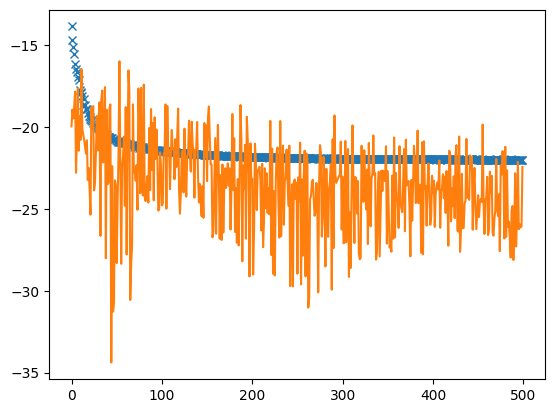

In [15]:
plt.plot(resTraining[:,0],'x')
plt.plot(resTraining_gumbel[:,0])
#plt.ylim(-10,10)

[]

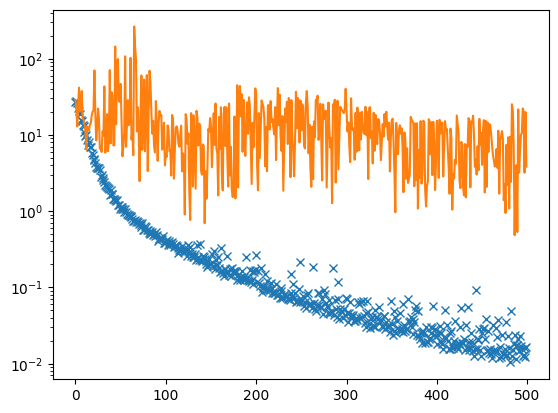

In [16]:
plt.plot(resTraining[:,1],'x')
plt.plot(resTraining_gumbel[:,1])
#plt.ylim(-10,10)
plt.semilogy()

In [17]:
sampler.sample(numSamples=16)

(Array([[[2, 1, 1, 0, 2, 0, 1, 0, 2, 1],
         [0, 2, 0, 1, 1, 1, 2, 0, 3, 0],
         [2, 1, 0, 0, 2, 0, 2, 3, 0, 0],
         [1, 1, 1, 3, 1, 0, 0, 1, 2, 0],
         [1, 2, 0, 0, 0, 1, 2, 1, 1, 2],
         [0, 4, 1, 1, 1, 0, 0, 1, 1, 1],
         [2, 2, 1, 0, 1, 1, 0, 1, 1, 1],
         [0, 1, 2, 3, 0, 2, 0, 1, 0, 1],
         [2, 1, 1, 3, 0, 1, 1, 1, 0, 0],
         [1, 1, 1, 0, 3, 0, 2, 2, 0, 0],
         [1, 0, 0, 1, 1, 1, 0, 3, 2, 1],
         [3, 1, 2, 1, 0, 1, 0, 1, 1, 0],
         [1, 1, 1, 1, 0, 0, 2, 1, 1, 2],
         [1, 0, 0, 3, 1, 3, 1, 0, 1, 0],
         [0, 1, 1, 3, 0, 1, 1, 3, 0, 0],
         [1, 1, 0, 1, 2, 0, 1, 2, 0, 2]]], dtype=int64),
 Array([[-4.98385505, -5.69492421, -6.11157882, -5.0710425 , -5.19269004,
         -5.31655417, -4.57687794, -5.35617025, -5.03476891, -5.63634755,
         -5.49181202, -5.0310413 , -4.7542995 , -5.78058275, -5.78933236,
         -5.09021027]], dtype=float64),
 Array([[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0

In [ ]:
a = sampler_gumbel.sample(numSamples=24)
a
psi_RWKV_gumbel.parameters

In [ ]:
import math
math.comb(5,2)

In [ ]:
a[0][0,jnp.argmax(a[1][0])]

In [ ]:
np.argmax(a[1][0])

In [ ]:
a[1][0,76]